In [1]:
from numpy import load
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit

In [2]:
filename1 = 'X_train.txt'
xtrain = np.loadtxt(filename1)
print(xtrain.shape)
filename2 = 'Y_train.txt'
ytrain = np.loadtxt(filename2)
ytrain=ytrain.reshape((7352,1))
print(ytrain.shape)
filename3 = 'X_test.txt'
xtest = np.loadtxt(filename3)
print(xtest.shape)
filename4 = 'Y_test.txt'
ytest = np.loadtxt(filename4)
ytest=ytest.reshape((2947,1))
print(ytest.shape)

(7352, 561)
(7352, 1)
(2947, 561)
(2947, 1)


In [3]:
N1=300
N2=200 #or 200
lr=0.001
mc=0 #momentum constant
batch=50

In [4]:
def init_w(N1,N2):
    WO = np.random.uniform(low=-0.1,high=0.1,size=(N1,561))
    WH1=np.random.uniform(low=-0.1,high=0.1,size=(N2,N1))
    WH2=np.random.uniform(low=-0.1,high=0.1,size=(6,N2))
    return WO,WH1,WH2

In [5]:
@jit
def RELU(x):  # used step here
        y = np.maximum(0, x)
        return y
@jit
def RELU_der(x):
    x[x>=0] = 1
    x[x<0] = 0
    return x

    return y
@jit
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
#def softmax(x):
 #   y = np.exp(x - np.max(x))
  #  return y / y.sum()

In [6]:
@jit
def train_net(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    err_arr=[]
    for e in range(100):
        true_predict = 0
        all_predict = 0
        miss=np.zeros((6,1))
        print("Epoch:", e+1)
        err=0
        pre_err=0
        pre_WO= np.zeros((N1,561))
        pre_WH1= np.zeros((N2,N1)) 
        pre_WH2= np.zeros((6,N2))
        for xi in range (len(X)):
            WO_grad= np.zeros((N1,561))
            WH1_grad= np.zeros((N2,N1)) 
            WH2_grad= np.zeros((6,N2))
            X_c=X[xi]
            #X_c=X_c.reshape((561,1))
            v1=np.dot(X_c,WO.T)
            v1=v1.reshape((1,N1))
            o1=RELU(v1)

            v2=np.matmul(o1,WH1.T)
            v2=v2.reshape((1,N2))
            o2=RELU(v2)

            v3=np.matmul(o2,WH2.T)
            y=softmax(v3)

            d=int(label[xi])
            y=y.reshape((6,1))
            err =err+(-np.log(y[d-1]+1e-4))
            #validation_err += err

            y=y.reshape((6,1))
            X_c=X_c.reshape((1,561))
            #backpropagation

            der=-y
            der[d-1]=1-y[d-1]
            WH2_grad  = WH2_grad+ lr*np.matmul(der,o2)  

            der2 = np.dot(np.dot(np.multiply(np.diag(np.ones(N2),0),RELU_der(v2).T),WH2.T),der)
            #print(der2.shape)
            WH1_grad=WH1_grad+lr* np.dot(der2,o1)

            der3 = np.dot(np.dot(np.multiply(np.diag(np.ones(N1),0),RELU_der(v1).T),WH1.T),der2)
            #print(der3.shape)
            WO_grad=WO_grad+lr*np.dot(der3,X_c)/10



            WH1 += WH1_grad + momentum*pre_WH1 # Momentum Update
            WH2 +=WH2_grad + momentum*pre_WH2# Momentum Update
            WO += WO_grad + momentum*pre_WO# Momentum Update

            #WH1=WH1/np.std(WH1)
            #WH2=WH2/np.std(WH2)
            #WO=WO/np.std(WO)



            pre_WH1 = WH1_grad 
            pre_WH2 = WH2_grad 
            pre_WO = WO_grad
            if np.argmax(y) == d:
                true_predict += 1
                all_predict += 1
            else:
                all_predict += 1
                for m in range(5):
                    if np.argmax(y)==m:
                        miss[m]+=1
          


            #if np.isnan(WO.any()):
                #print("Error")
           # WH1 = WH1+np.matmul(np.matmul(WH2.T,(label-y))*RELU_der(a2),v1_c.T)               
            #WH1_grad = np.matmd-1l(np.matmul(WH2.T,np.matmul(WO.T,(label-y))*RELU_der(a2)*RELU_der(a1)),X.T)

        print("Error: ", err/len(ytrain))
        err_arr.append(err/len(ytrain))
        #miss=np.zeros((6,1)) 
    print(miss) 
    plt.plot(err_arr)
    return y,v1,v2,v3,err

In [7]:
#Test Code
@jit
def test():
    true_predict = 0
    all_predict = 0
    miss=np.zeros((6,1))
    mis1=0
    mis2=0
    mis3=0
    mis4=0
    mis5=0
    mis6=0
    for element in range(len(xtest)):
        x_e = xtest[element]
        x_e = np.reshape(x_e, (1,561))
        v1_t = np.matmul(x_e,WO.T)
        o1_t = RELU(v1_t)
        v2_t = np.matmul( o1_t,WH1.T)
        o2_t = RELU(v2_t)
        v3_t = np.matmul (o2_t,WH2.T)
        out = softmax(v3_t)
        out = np.reshape(out, (6,1))

        d_t = ytest[element]
        d_t = int(d_t) - 1
        out=out.reshape((6,1))
        x_e=x_e.reshape((1,561))

        if np.argmax(out) == d_t:
            true_predict += 1
            all_predict += 1
        else:
            all_predict += 1
            for m in range(5):
                if np.argmax(out)==m:
                    miss[m]+=1
    print(miss)
    miss=np.zeros((6,1))            


    print("Test Accuracy (%): ", 100* (true_predict/all_predict))

<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_net" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(array(float64, 1d, C))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
      With argument(s): '(array(float64, 1d, C))':
     No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-6-1b34ac4e9be7> (33)


File "<ipython-input-6-1b34ac4e9be7>", line 33:
def train_net(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    <source elided>

            d=int(label[xi])
            ^

  @jit
<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "train_net" failed type inference due to: cannot deter

Epoch: 1
Error:  [0.70018147]
Epoch: 2
Error:  [0.27619843]
Epoch: 3
Error:  [0.17212676]
Epoch: 4
Error:  [0.12722504]
Epoch: 5
Error:  [0.10295193]
Epoch: 6
Error:  [0.08769301]
Epoch: 7
Error:  [0.07696936]
Epoch: 8
Error:  [0.06891022]
Epoch: 9
Error:  [0.0625917]
Epoch: 10
Error:  [0.0574909]
Epoch: 11
Error:  [0.05329955]
Epoch: 12
Error:  [0.04970573]
Epoch: 13
Error:  [0.04656858]
Epoch: 14
Error:  [0.0438057]
Epoch: 15
Error:  [0.04135275]
Epoch: 16
Error:  [0.03909572]
Epoch: 17
Error:  [0.03709339]
Epoch: 18
Error:  [0.03530076]
Epoch: 19
Error:  [0.03367554]
Epoch: 20
Error:  [0.03220533]
Epoch: 21
Error:  [0.03081765]
Epoch: 22
Error:  [0.02953606]
Epoch: 23
Error:  [0.02833529]
Epoch: 24
Error:  [0.02723167]
Epoch: 25
Error:  [0.0262138]
Epoch: 26
Error:  [0.02524143]
Epoch: 27
Error:  [0.0243458]
Epoch: 28
Error:  [0.02350219]
Epoch: 29
Error:  [0.02269382]
Epoch: 30
Error:  [0.02192308]
Epoch: 31
Error:  [0.02118514]
Epoch: 32
Error:  [0.02049517]
Epoch: 33
Error:  [0.0

<ipython-input-8-d5f630f76443>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "test" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(readonly array(float64, 1d, C))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
        With argument(s): '(readonly array(float64, 1d, C))':
       No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-8-d5f630f76443> (25)


File "<ipython-input-8-d5f630f76443>", line 25:
def test():
    <source elided>
        des_test = ytest[test_ind]
        des_test = int(des_test) - 1
        ^

  @jit
<ipython-input-8-d5f630f76443>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "test" failed type inference due to: canno

[[23.]
 [37.]
 [13.]
 [61.]
 [65.]
 [ 0.]]
Test Accuracy (%):  93.24737020699015


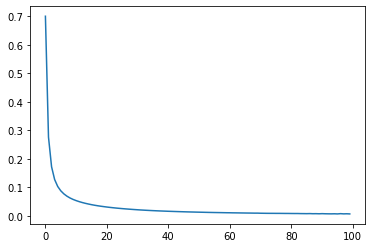

In [9]:
#Hls1 = 300, Hls2 = 100, Learn Coef = 0.001, Momentum = 0, Online Learning
WO,WH1,WH2= init_w(300,100)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,100,1,0.001,0)
test()


Epoch: 1
Error:  [0.65682727]
Epoch: 2
Error:  [0.23032919]
Epoch: 3
Error:  [0.14381719]
Epoch: 4
Error:  [0.11030315]
Epoch: 5
Error:  [0.09144866]
Epoch: 6
Error:  [0.07894296]
Epoch: 7
Error:  [0.07004765]
Epoch: 8
Error:  [0.06336758]
Epoch: 9
Error:  [0.05811013]
Epoch: 10
Error:  [0.05378173]
Epoch: 11
Error:  [0.05016581]
Epoch: 12
Error:  [0.04705571]
Epoch: 13
Error:  [0.04431744]
Epoch: 14
Error:  [0.04192108]
Epoch: 15
Error:  [0.03984144]
Epoch: 16
Error:  [0.03794981]
Epoch: 17
Error:  [0.03625121]
Epoch: 18
Error:  [0.0346978]
Epoch: 19
Error:  [0.0332943]
Epoch: 20
Error:  [0.03194976]
Epoch: 21
Error:  [0.03074263]
Epoch: 22
Error:  [0.02958283]
Epoch: 23
Error:  [0.02853556]
Epoch: 24
Error:  [0.02752289]
Epoch: 25
Error:  [0.02657842]
Epoch: 26
Error:  [0.0256961]
Epoch: 27
Error:  [0.02487802]
Epoch: 28
Error:  [0.02410113]
Epoch: 29
Error:  [0.02333922]
Epoch: 30
Error:  [0.02266154]
Epoch: 31
Error:  [0.02199068]
Epoch: 32
Error:  [0.02137202]
Epoch: 33
Error:  [0

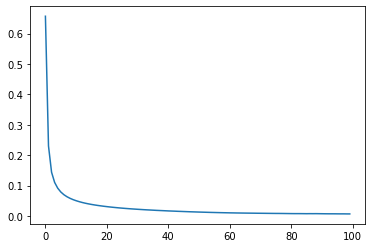

In [10]:
#Hls1 = 300, Hls2 = 200, Learn Coef = 0.001, Momentum = 0, Online Learning
WO,WH1,WH2= init_w(300,200)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,200,1,0.001,0)
test()

<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_net" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(array(float64, 1d, C))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
        With argument(s): '(array(float64, 1d, C))':
       No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-6-1b34ac4e9be7> (33)


File "<ipython-input-6-1b34ac4e9be7>", line 33:
def train_net(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    <source elided>

            d=int(label[xi])
            ^

  @jit
<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "train_net" failed type inference due to: cann

Epoch: 1
Error:  [0.43874909]
Epoch: 2
Error:  [0.15439243]
Epoch: 3
Error:  [0.10175081]
Epoch: 4
Error:  [0.07965247]
Epoch: 5
Error:  [0.06797951]
Epoch: 6
Error:  [0.06044177]
Epoch: 7
Error:  [0.05499327]
Epoch: 8
Error:  [0.0507319]
Epoch: 9
Error:  [0.04725584]
Epoch: 10
Error:  [0.04431968]
Epoch: 11
Error:  [0.04177348]
Epoch: 12
Error:  [0.03938324]
Epoch: 13
Error:  [0.03730686]
Epoch: 14
Error:  [0.03525592]
Epoch: 15
Error:  [0.03354183]
Epoch: 16
Error:  [0.03187824]
Epoch: 17
Error:  [0.03039277]
Epoch: 18
Error:  [0.02894441]
Epoch: 19
Error:  [0.02774388]
Epoch: 20
Error:  [0.0265307]
Epoch: 21
Error:  [0.02549245]
Epoch: 22
Error:  [0.02445482]
Epoch: 23
Error:  [0.02336683]
Epoch: 24
Error:  [0.02244942]
Epoch: 25
Error:  [0.02152371]
Epoch: 26
Error:  [0.02064718]
Epoch: 27
Error:  [0.0198354]
Epoch: 28
Error:  [0.01917531]
Epoch: 29
Error:  [0.01843028]
Epoch: 30
Error:  [0.01777209]
Epoch: 31
Error:  [0.01704454]
Epoch: 32
Error:  [0.01657583]
Epoch: 33
Error:  [0

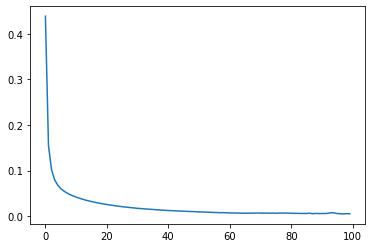

In [11]:
#Hls1 = 300, Hls2 = 200, Learn Coef = 0.001, Momentum = 0, Online Learning
WO,WH1,WH2= init_w(300,200)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,200,1,0.001,0.9)
test()

Epoch: 1
Error:  [0.17885859]
Epoch: 2
Error:  [0.05711529]
Epoch: 3
Error:  [0.04128792]
Epoch: 4
Error:  [0.03592082]
Epoch: 5
Error:  [0.03221128]
Epoch: 6
Error:  [0.02999447]
Epoch: 7
Error:  [0.02853484]
Epoch: 8
Error:  [0.02804377]
Epoch: 9
Error:  [0.02682636]
Epoch: 10
Error:  [0.02428323]
Epoch: 11
Error:  [0.02358463]
Epoch: 12
Error:  [0.02081505]
Epoch: 13
Error:  [0.01946391]
Epoch: 14
Error:  [0.01838968]
Epoch: 15
Error:  [0.01839816]
Epoch: 16
Error:  [0.01839695]
Epoch: 17
Error:  [0.01718597]
Epoch: 18
Error:  [0.01470221]
Epoch: 19
Error:  [0.01786798]
Epoch: 20
Error:  [0.01629793]
Epoch: 21
Error:  [0.01587424]
Epoch: 22
Error:  [0.01740496]
Epoch: 23
Error:  [0.01783792]
Epoch: 24
Error:  [0.01422018]
Epoch: 25
Error:  [0.01470819]
Epoch: 26
Error:  [0.01207544]
Epoch: 27
Error:  [0.01288351]
Epoch: 28
Error:  [0.01048863]
Epoch: 29
Error:  [0.01469009]
Epoch: 30
Error:  [0.01537252]
Epoch: 31
Error:  [0.01642556]
Epoch: 32
Error:  [0.01559874]
Epoch: 33
Error: 

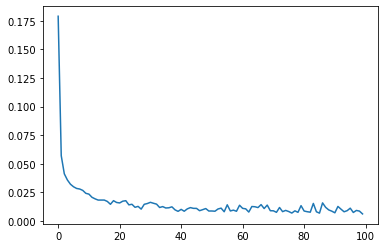

In [12]:
#Hls1 = 300, Hls2 = 100, Learn Coef = 0.01, Momentum = 0, Online Learning
WO,WH1,WH2= init_w(300,100)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,100,1,0.01,0)
test()

<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_net" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(array(float64, 1d, C))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
      With argument(s): '(array(float64, 1d, C))':
     No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-6-1b34ac4e9be7> (33)


File "<ipython-input-6-1b34ac4e9be7>", line 33:
def train_net(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    <source elided>

            d=int(label[xi])
            ^

  @jit
<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "train_net" failed type inference due to: cannot deter

Epoch: 1
Error:  [0.16879641]
Epoch: 2
Error:  [0.05369044]
Epoch: 3
Error:  [0.03966969]
Epoch: 4
Error:  [0.03316351]
Epoch: 5
Error:  [0.02935961]
Epoch: 6
Error:  [0.02752228]
Epoch: 7
Error:  [0.0271318]
Epoch: 8
Error:  [0.02521842]
Epoch: 9
Error:  [0.02559589]
Epoch: 10
Error:  [0.02292857]
Epoch: 11
Error:  [0.02261222]
Epoch: 12
Error:  [0.01992289]
Epoch: 13
Error:  [0.01925325]
Epoch: 14
Error:  [0.01977758]
Epoch: 15
Error:  [0.01780305]
Epoch: 16
Error:  [0.01699764]
Epoch: 17
Error:  [0.01859124]
Epoch: 18
Error:  [0.0170806]
Epoch: 19
Error:  [0.01606745]
Epoch: 20
Error:  [0.01509506]
Epoch: 21
Error:  [0.01323612]
Epoch: 22
Error:  [0.01554085]
Epoch: 23
Error:  [0.01357546]
Epoch: 24
Error:  [0.01541353]
Epoch: 25
Error:  [0.01207882]
Epoch: 26
Error:  [0.01445812]
Epoch: 27
Error:  [0.01324953]
Epoch: 28
Error:  [0.01183803]
Epoch: 29
Error:  [0.01303838]
Epoch: 30
Error:  [0.01112049]
Epoch: 31
Error:  [0.01398667]
Epoch: 32
Error:  [0.01057419]
Epoch: 33
Error:  [

<ipython-input-7-d5f630f76443>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "test" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(readonly array(float64, 1d, C))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
        With argument(s): '(readonly array(float64, 1d, C))':
       No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-7-d5f630f76443> (25)


File "<ipython-input-7-d5f630f76443>", line 25:
def test():
    <source elided>
        des_test = ytest[test_ind]
        des_test = int(des_test) - 1
        ^

  @jit
<ipython-input-7-d5f630f76443>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "test" failed type inference due to: canno

[[ 35.]
 [ 11.]
 [ 55.]
 [217.]
 [ 24.]
 [  0.]]
Test Accuracy (%):  88.39497794367152


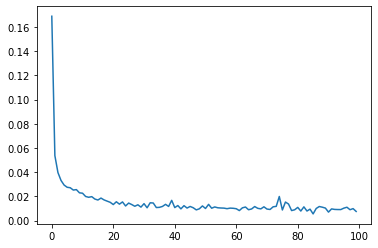

In [8]:
#Hls1 = 300, Hls2 = 200, Learn Coef = 0.01, Momentum = 0, Online Learning
WO,WH1,WH2= init_w(300,200)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,200,1,0.01,0)
test()

<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_net" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(array(float64, 1d, C))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
        With argument(s): '(array(float64, 1d, C))':
       No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-6-1b34ac4e9be7> (33)


File "<ipython-input-6-1b34ac4e9be7>", line 33:
def train_net(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    <source elided>

            d=int(label[xi])
            ^

  @jit
<ipython-input-6-1b34ac4e9be7>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "train_net" failed type inference due to: cann

Epoch: 1
Error:  [0.54911702]
Epoch: 2
Error:  [0.18440033]
Epoch: 3
Error:  [0.11227608]
Epoch: 4
Error:  [0.08438305]
Epoch: 5
Error:  [0.07083791]
Epoch: 6
Error:  [0.06283951]
Epoch: 7
Error:  [0.05710888]
Epoch: 8
Error:  [0.05295079]
Epoch: 9
Error:  [0.04953784]
Epoch: 10
Error:  [0.04672958]
Epoch: 11
Error:  [0.04419867]
Epoch: 12
Error:  [0.04165871]
Epoch: 13
Error:  [0.03945705]
Epoch: 14
Error:  [0.03749035]
Epoch: 15
Error:  [0.03581886]
Epoch: 16
Error:  [0.03411942]
Epoch: 17
Error:  [0.03265011]
Epoch: 18
Error:  [0.03136604]
Epoch: 19
Error:  [0.03023035]
Epoch: 20
Error:  [0.02907561]
Epoch: 21
Error:  [0.02812027]
Epoch: 22
Error:  [0.02722124]
Epoch: 23
Error:  [0.02632867]
Epoch: 24
Error:  [0.0254506]
Epoch: 25
Error:  [0.02460848]
Epoch: 26
Error:  [0.02386297]
Epoch: 27
Error:  [0.02316154]
Epoch: 28
Error:  [0.02247014]
Epoch: 29
Error:  [0.0218348]
Epoch: 30
Error:  [0.02117337]
Epoch: 31
Error:  [0.02058728]
Epoch: 32
Error:  [0.02009832]
Epoch: 33
Error:  [

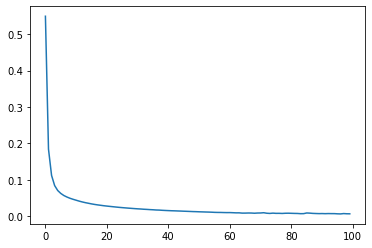

In [9]:
WO,WH1,WH2= init_w(300,100)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,100,1,0.001,0.9)
test()

Epoch: 1
Error:  [0.19559476]
Epoch: 2
Error:  [0.06567887]
Epoch: 3
Error:  [0.05301272]
Epoch: 4
Error:  [0.0515185]
Epoch: 5
Error:  [0.04775585]
Epoch: 6
Error:  [0.04958657]
Epoch: 7
Error:  [0.04230429]
Epoch: 8
Error:  [0.04266436]
Epoch: 9
Error:  [0.03774621]
Epoch: 10
Error:  [0.03996484]
Epoch: 11
Error:  [0.03787666]
Epoch: 12
Error:  [0.03781355]
Epoch: 13
Error:  [0.03737402]
Epoch: 14
Error:  [0.03656279]
Epoch: 15
Error:  [0.03334763]
Epoch: 16
Error:  [0.03248647]
Epoch: 17
Error:  [0.03090847]
Epoch: 18
Error:  [0.03601363]
Epoch: 19
Error:  [0.03280139]
Epoch: 20
Error:  [0.02782456]
Epoch: 21
Error:  [0.02769943]
Epoch: 22
Error:  [0.02692128]
Epoch: 23
Error:  [0.02874913]
Epoch: 24
Error:  [0.02500558]
Epoch: 25
Error:  [0.02498812]
Epoch: 26
Error:  [0.02669116]
Epoch: 27
Error:  [0.02346346]
Epoch: 28
Error:  [0.03027205]
Epoch: 29
Error:  [0.02800055]
Epoch: 30
Error:  [0.03029623]
Epoch: 31
Error:  [0.02316064]
Epoch: 32
Error:  [0.02966598]
Epoch: 33
Error:  

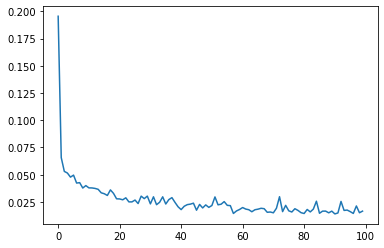

In [10]:
WO,WH1,WH2= init_w(300,100)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,100,1,0.01,0.9)
test()

Epoch: 1
Error:  [0.18719376]
Epoch: 2
Error:  [0.07206747]
Epoch: 3
Error:  [0.05509517]
Epoch: 4
Error:  [0.04824763]
Epoch: 5
Error:  [0.04688937]
Epoch: 6
Error:  [0.04221298]
Epoch: 7
Error:  [0.04361842]
Epoch: 8
Error:  [0.04571686]
Epoch: 9
Error:  [0.04298325]
Epoch: 10
Error:  [0.0382875]
Epoch: 11
Error:  [0.04013174]
Epoch: 12
Error:  [0.03714717]
Epoch: 13
Error:  [0.0385108]
Epoch: 14
Error:  [0.04026064]
Epoch: 15
Error:  [0.02798525]
Epoch: 16
Error:  [0.03171446]
Epoch: 17
Error:  [0.03322684]
Epoch: 18
Error:  [0.02841815]
Epoch: 19
Error:  [0.02843651]
Epoch: 20
Error:  [0.02842785]
Epoch: 21
Error:  [0.02511042]
Epoch: 22
Error:  [0.02990745]
Epoch: 23
Error:  [0.02475433]
Epoch: 24
Error:  [0.02929403]
Epoch: 25
Error:  [0.02678966]
Epoch: 26
Error:  [0.02433584]
Epoch: 27
Error:  [0.02162782]
Epoch: 28
Error:  [0.03136191]
Epoch: 29
Error:  [0.02828631]
Epoch: 30
Error:  [0.02413695]
Epoch: 31
Error:  [0.02402918]
Epoch: 32
Error:  [0.02192138]
Epoch: 33
Error:  [

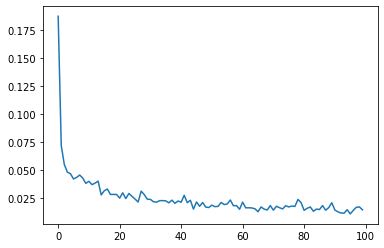

In [11]:
#Hls1 = 300, Hls2 = 200, Learn Coef = 0.01, Momentum = 0, Online Learning
WO,WH1,WH2= init_w(300,200)
train_net(xtrain,ytrain,WH1,WH2,WO,N1,200,1,0.01,0.9)
test()

In [12]:
#minibatch train
@jit
def train_minibatch(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    ytrain_val=label[: 750]
    xtrain_val=X[: 750]
    err_arr=[]
    pre_err=100
    for e in range(100):
        print("Epoch:", e+1)
        err=0
        err1=0
        true_predict = 0
        all_predict = 0
        miss=np.zeros((6,1))
        #pre_err=0
        #X=X[len(X)-750:]
        pre_WO= np.zeros((N1,561))
        pre_WH1= np.zeros((N2,N1)) 
        pre_WH2= np.zeros((6,N2))
        for k in range(len(xtrain)//batch):
            #forward 
            for i in range(batch*k,batch*(k+1)):
                WO_grad= np.zeros((N1,561))
                WH1_grad= np.zeros((N2,N1)) 
                WH2_grad= np.zeros((6,N2))
                X_c=X[i]
                #X_c=X_c.reshape((561,1))
                v1=np.dot(X_c,WO.T)
                v1=v1.reshape((1,N1))
                o1=RELU(v1)

                v2=np.matmul(o1,WH1.T)
                v2=v2.reshape((1,N2))
                o2=RELU(v2)

                v3=np.matmul(o2,WH2.T)
                y=softmax(v3)

                d=int(label[i])
                y=y.reshape((6,1))
                #X_c=X_c.reshape((1,561))
                err =err+(-np.math.log(y[d-1]+1e-4,2))
                

                y=y.reshape((6,1))
                X_c=X_c.reshape((1,561))
                #backpropagation
            #while(ahsen):
          
                der=-y
                der[d-1]=1-y[d-1]
                WH2_grad  = WH2_grad+ lr*np.matmul(der,o2)  

                der2 = np.dot(np.dot(np.multiply(np.diag(np.ones(N2),0),RELU_der(v2).T),WH2.T),der)
                #print(der2.shape)
                WH1_grad=WH1_grad+lr* np.dot(der2,o1)

                der3 = np.dot(np.dot(np.multiply(np.diag(np.ones(N1),0),RELU_der(v1).T),WH1.T),der2)
                #print(der3.shape)
                WO_grad=WO_grad+lr*np.dot(der3,X_c)/10



                WH1 += WH1_grad + momentum*pre_WH1 # Momentum Update
                WH2 +=WH2_grad + momentum*pre_WH2# Momentum Update
                WO += WO_grad + momentum*pre_WO# Momentum Update

                #WH1=WH1/np.std(WH1)
                #WH2=WH2/np.std(WH2)
                #WO=WO/np.std(WO)



                pre_WH1 = WH1_grad 
                pre_WH2 = WH2_grad 
                pre_WO = WO_grad
            #if (err_pre>err):
             #   ahsen = False
                #if np.isnan(WO.any()):
                    #print("Error")
               # WH1 = WH1+np.matmul(np.matmul(WH2.T,(label-y))*RELU_der(a2),v1_c.T)               
                #WH1_grad = np.matmd-1l(np.matmul(WH2.T,np.matmul(WO.T,(label-y))*RELU_der(a2)*RELU_der(a1)),X.T)
        print("Error:", err/len(ytrain))
        err_arr.append(err/len(ytrain))
    plt.plot(err_arr)
    return y,v1,v2,v3,err

In [25]:
a=train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,N2,50,lr,0)[0]
a

Epoch: 1


KeyboardInterrupt: 

<ipython-input-12-c1a1296d309c>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_minibatch" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(array(float64, 1d, C))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
        With argument(s): '(array(float64, 1d, C))':
       No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-12-c1a1296d309c> (31)


File "<ipython-input-12-c1a1296d309c>", line 31:
def train_minibatch(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    <source elided>

                d=int(label[i])
                ^

  @jit
<ipython-input-12-c1a1296d309c>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "train_minibatch" faile

Epoch: 1
Error: 0.7663929784452443
Epoch: 2
Error: 0.24667231006470663
Epoch: 3
Error: 0.16139880592675737
Epoch: 4
Error: 0.12617897544616882
Epoch: 5
Error: 0.10688286151501765
Epoch: 6
Error: 0.09545835889485468
Epoch: 7
Error: 0.08736721572516926
Epoch: 8
Error: 0.08134771976243234
Epoch: 9
Error: 0.07639585596174317
Epoch: 10
Error: 0.07235930301013122
Epoch: 11
Error: 0.06866217789532406
Epoch: 12
Error: 0.06493941781745813
Epoch: 13
Error: 0.061952955650407746
Epoch: 14
Error: 0.05899922563166829
Epoch: 15
Error: 0.0560900015669244
Epoch: 16
Error: 0.0534770809486965
Epoch: 17
Error: 0.05114261081344213
Epoch: 18
Error: 0.04885119940771107
Epoch: 19
Error: 0.0467910082322078
Epoch: 20
Error: 0.04457265095006558
Epoch: 21
Error: 0.04254981822410333
Epoch: 22
Error: 0.04093533085261564
Epoch: 23
Error: 0.03923187480995408
Epoch: 24
Error: 0.037757668797079535
Epoch: 25
Error: 0.03627518336265713
Epoch: 26
Error: 0.03473087247120754
Epoch: 27
Error: 0.03350779801734339
Epoch: 28
Er

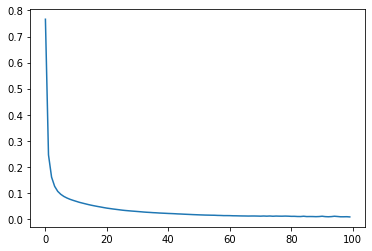

In [13]:
WO,WH1,WH2= init_w(300,100)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,100,50,0.001,0.9)
test()

<ipython-input-12-c1a1296d309c>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_minibatch" failed type inference due to: No implementation of function Function(<class 'int'>) found for signature:
 
 >>> int(array(float64, 1d, C))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'int': File: numba\core\typing\builtins.py: Line 927.
        With argument(s): '(array(float64, 1d, C))':
       No match.

During: resolving callee type: Function(<class 'int'>)
During: typing of call at <ipython-input-12-c1a1296d309c> (31)


File "<ipython-input-12-c1a1296d309c>", line 31:
def train_minibatch(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum):
    <source elided>

                d=int(label[i])
                ^

  @jit
<ipython-input-12-c1a1296d309c>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "train_minibatch" faile

Epoch: 1
Error: 1.0747414025411812
Epoch: 2
Error: 0.39510359115649507
Epoch: 3
Error: 0.24229407288769525
Epoch: 4
Error: 0.18121460138967088
Epoch: 5
Error: 0.14876194912589827
Epoch: 6
Error: 0.12763287513994592
Epoch: 7
Error: 0.11258809583121943
Epoch: 8
Error: 0.10101469826585684
Epoch: 9
Error: 0.09161235387785158
Epoch: 10
Error: 0.08415443025019884
Epoch: 11
Error: 0.0779666335102465
Epoch: 12
Error: 0.07264747087755447
Epoch: 13
Error: 0.06794341244333812
Epoch: 14
Error: 0.06396332253792446
Epoch: 15
Error: 0.06025001684623809
Epoch: 16
Error: 0.05703305436982709
Epoch: 17
Error: 0.054113277276796205
Epoch: 18
Error: 0.0515605076115304
Epoch: 19
Error: 0.04924469841140491
Epoch: 20
Error: 0.0470085247923509
Epoch: 21
Error: 0.04505708457760159
Epoch: 22
Error: 0.043184186738986455
Epoch: 23
Error: 0.04139275343060025
Epoch: 24
Error: 0.039863168604418506
Epoch: 25
Error: 0.038279941413726225
Epoch: 26
Error: 0.036876322337666925
Epoch: 27
Error: 0.035583775255389354
Epoch: 2

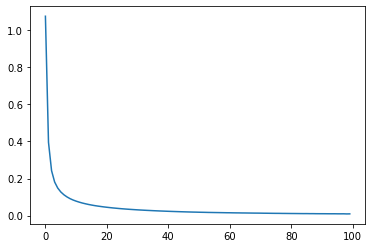

In [14]:
WO,WH1,WH2= init_w(300,100)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,100,50,0.001,0)
test()

Epoch: 1
Error: 0.2947876238312005
Epoch: 2
Error: 0.08602710942727017
Epoch: 3
Error: 0.06049342259858946
Epoch: 4
Error: 0.050968882677294464
Epoch: 5
Error: 0.045512006613481974
Epoch: 6
Error: 0.04294341902398251
Epoch: 7
Error: 0.04049519281903951
Epoch: 8
Error: 0.037416776151682575
Epoch: 9
Error: 0.03530228613757575
Epoch: 10
Error: 0.03221336820111857
Epoch: 11
Error: 0.03127306445410432
Epoch: 12
Error: 0.03101327546230664
Epoch: 13
Error: 0.02920020598178601
Epoch: 14
Error: 0.028398354299853754
Epoch: 15
Error: 0.026043908387291093
Epoch: 16
Error: 0.024379147419645662
Epoch: 17
Error: 0.022462272019619763
Epoch: 18
Error: 0.02149700109269211
Epoch: 19
Error: 0.020095552147342394
Epoch: 20
Error: 0.01832495332719807
Epoch: 21
Error: 0.021769331199657637
Epoch: 22
Error: 0.019891540150786743
Epoch: 23
Error: 0.022742906326493516
Epoch: 24
Error: 0.021271525088718952
Epoch: 25
Error: 0.018501823236089465
Epoch: 26
Error: 0.02054835416090222
Epoch: 27
Error: 0.0257386761008774

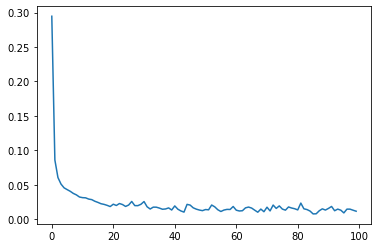

In [15]:
WO,WH1,WH2= init_w(300,100)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,100,50,0.01,0)
test()

Epoch: 1
Error: 0.29591900363887574
Epoch: 2
Error: 0.10759161839697656
Epoch: 3
Error: 0.0804361764288337
Epoch: 4
Error: 0.07588427647411566
Epoch: 5
Error: 0.07292764990709237
Epoch: 6
Error: 0.06298963512968388
Epoch: 7
Error: 0.06588670389262992
Epoch: 8
Error: 0.06699599005588497
Epoch: 9
Error: 0.059966852872648864
Epoch: 10
Error: 0.06537509309649084
Epoch: 11
Error: 0.05333716484203786
Epoch: 12
Error: 0.05132580769545534
Epoch: 13
Error: 0.05052382938826372
Epoch: 14
Error: 0.051126626157493034
Epoch: 15
Error: 0.048309968724677375
Epoch: 16
Error: 0.05091070774277316
Epoch: 17
Error: 0.046088647212186626
Epoch: 18
Error: 0.04397383742866847
Epoch: 19
Error: 0.04010854145310445
Epoch: 20
Error: 0.038264845153042244
Epoch: 21
Error: 0.03681350644665529
Epoch: 22
Error: 0.048290536542982675
Epoch: 23
Error: 0.0375456079900726
Epoch: 24
Error: 0.045011606538549305
Epoch: 25
Error: 0.04450557763583126
Epoch: 26
Error: 0.03979326919541142
Epoch: 27
Error: 0.036136570991134855
Epoc

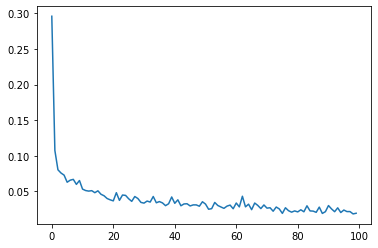

In [16]:
WO,WH1,WH2= init_w(300,100)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,100,50,0.01,0.9)
test()

Epoch: 1
Error: 0.937048812512366
Epoch: 2
Error: 0.34678529863141244
Epoch: 3
Error: 0.22141282759416622
Epoch: 4
Error: 0.1685548792465136
Epoch: 5
Error: 0.13863355251087708
Epoch: 6
Error: 0.1190564402793868
Epoch: 7
Error: 0.10523122668861819
Epoch: 8
Error: 0.09487123165002101
Epoch: 9
Error: 0.08673469460347606
Epoch: 10
Error: 0.0801543757853797
Epoch: 11
Error: 0.07469482381457838
Epoch: 12
Error: 0.0700570917660448
Epoch: 13
Error: 0.06598663998730682
Epoch: 14
Error: 0.06234108937873865
Epoch: 15
Error: 0.059179990367120384
Epoch: 16
Error: 0.05625246132859912
Epoch: 17
Error: 0.05364775391850509
Epoch: 18
Error: 0.05120996400442674
Epoch: 19
Error: 0.04895954563736036
Epoch: 20
Error: 0.04690404205586416
Epoch: 21
Error: 0.0449357500513736
Epoch: 22
Error: 0.04321602917874464
Epoch: 23
Error: 0.04155481627249703
Epoch: 24
Error: 0.03991522959091314
Epoch: 25
Error: 0.03849216763084351
Epoch: 26
Error: 0.037139113827982205
Epoch: 27
Error: 0.035922537738263524
Epoch: 28
Erro

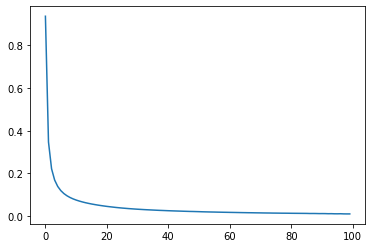

In [17]:
WO,WH1,WH2= init_w(300,200)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,200,50,0.001,0)
test()

Epoch: 1
Error: 0.6980264739584325
Epoch: 2
Error: 0.23720168249935542
Epoch: 3
Error: 0.15267290166663244
Epoch: 4
Error: 0.11827437053420936
Epoch: 5
Error: 0.09983366163786106
Epoch: 6
Error: 0.08816459095748239
Epoch: 7
Error: 0.079821175477724
Epoch: 8
Error: 0.07314026907358914
Epoch: 9
Error: 0.06760343311725958
Epoch: 10
Error: 0.06281160429747137
Epoch: 11
Error: 0.05880613653197925
Epoch: 12
Error: 0.0551887169628598
Epoch: 13
Error: 0.051936213761982326
Epoch: 14
Error: 0.04912693509282922
Epoch: 15
Error: 0.04657879974961214
Epoch: 16
Error: 0.044152750567761946
Epoch: 17
Error: 0.04205421547164757
Epoch: 18
Error: 0.04024924432495745
Epoch: 19
Error: 0.038373981414952074
Epoch: 20
Error: 0.03665517033517067
Epoch: 21
Error: 0.03536301796651305
Epoch: 22
Error: 0.03405290026905069
Epoch: 23
Error: 0.0325137828894669
Epoch: 24
Error: 0.03134123379548639
Epoch: 25
Error: 0.030067351364960197
Epoch: 26
Error: 0.028802568111231802
Epoch: 27
Error: 0.027882661904726436
Epoch: 28

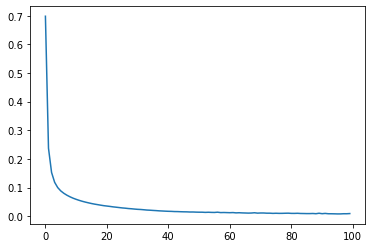

In [18]:
WO,WH1,WH2= init_w(300,200)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,200,50,0.001,0.9)
test()

In [ ]:
WO,WH1,WH2= init_w(300,200)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,200,50,0.01,0)
test()

Epoch: 1
Error: 0.21096977113681725
Epoch: 2
Error: 0.0718642427157299
Epoch: 3
Error: 0.05516150894027319
Epoch: 4
Error: 0.04802195639164076
Epoch: 5
Error: 0.044605282651936334
Epoch: 6
Error: 0.040945555383071854
Epoch: 7
Error: 0.036280813245994824
Epoch: 8
Error: 0.03623541360740168
Epoch: 9


In [ ]:
WO,WH1,WH2= init_w(300,200)
train_minibatch(xtrain,ytrain,WH1,WH2,WO,N1,200,50,0.01,0.9)
test()

In [ ]:
@jit
def dropout_net(X,label,WH1,WH2,WO,N1,N2,batch,lr,momentum,p):
    ytrain_val=label[: 750]
    xtrain_val=X[: 750]
    pre_err=100
    err_arr=[]
    for e in range(100):
        print("Epoch:", e+1)
        err=0

        pre_WO= np.zeros((N1,561))
        pre_WH1= np.zeros((N2,N1)) 
        pre_WH2= np.zeros((6,N2))
        for k in range(len(xtrain)//batch):
            #forward 
            for i in range(batch*k,batch*(k+1)):
                WO_grad= np.zeros((N1,561))
                WH1_grad= np.zeros((N2,N1)) 
                WH2_grad= np.zeros((6,N2))
                X_c=X[i]
                #X_c=X_c.reshape((561,1))
                v1=np.dot(X_c,WO.T)
                v1=v1.reshape((1,N1))
                o1=RELU(v1)

                #o1=np.vstack((o1,-np.ones(shape=(300,1))))
                o1= np.random.binomial(1,1-p,size=o1.shape)*o1
                v2=np.matmul(o1,WH1.T)
                v2=v2.reshape((1,N2))
                o2=RELU(v2)

                v3=np.matmul(o2,WH2.T)
                y=softmax(v3)

                d=int(label[i])
                y=y.reshape((6,1))
                #X_c=X_c.reshape((1,561))
                err =err+(-np.math.log(y[d-1]+1e-4,2))
                

                y=y.reshape((6,1))
                X_c=X_c.reshape((1,561))
                #backpropagation
            #while(ahsen):
          
                der=-y
                der[d-1]=1-y[d-1]
                WH2_grad  = WH2_grad+ lr*np.matmul(der,o2)  

                der2 = np.dot(np.dot(np.multiply(np.diag(np.ones(N2),0),RELU_der(v2).T),WH2.T),der)
                #print(der2.shape)
                WH1_grad=WH1_grad+lr* np.dot(der2,o1)

                der3 = np.dot(np.dot(np.multiply(np.diag(np.ones(N1),0),RELU_der(v1).T),WH1.T),der2)
                #print(der3.shape)
                WO_grad=WO_grad+lr*np.dot(der3,X_c)/10



                WH1 += WH1_grad + momentum*pre_WH1 # Momentum Update
                WH2 +=WH2_grad + momentum*pre_WH2# Momentum Update
                WO += WO_grad + momentum*pre_WO# Momentum Update

                #WH1=WH1/np.std(WH1)
                #WH2=WH2/np.std(WH2)
                #WO=WO/np.std(WO)



                pre_WH1 = WH1_grad 
                pre_WH2 = WH2_grad 
                pre_WO = WO_grad
            #if (err_pre>err):
             #   ahsen = False
                #if np.isnan(WO.any()):
                    #print("Error")
               # WH1 = WH1+np.matmul(np.matmul(WH2.T,(label-y))*RELU_der(a2),v1_c.T)               
                #WH1_grad = np.matmd-1l(np.matmul(WH2.T,np.matmul(WO.T,(label-y))*RELU_der(a2)*RELU_der(a1)),X.T)
        print("Error:", err/len(ytrain))
        #if (err/(len(ytrain))>pre_err):
         #   break
        #pre_err=err/(len(ytrain))
        err_arr.append(err/len(ytrain))
    plt.plot(err_arr)
    return y,v1,v2,v3,err

In [ ]:
WO,WH1,WH2= init_w(300,200)
dropout_net(xtrain,ytrain,WH1,WH2,WO,N1,200,50,0.001,0,0.5)
test()